In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch

In [2]:
data = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Bitext_Sample_Customer_Support_Training_(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

In [4]:
data.set_format(type='pandas')

In [5]:
df = data['train'][:]
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


# Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26872 entries, 0 to 26871
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   flags        26872 non-null  object
 1   instruction  26872 non-null  object
 2   category     26872 non-null  object
 3   intent       26872 non-null  object
 4   response     26872 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [7]:
df.isnull().sum()

,0
flags,0
instruction,0
category,0
intent,0
response,0


In [8]:
empty_instructions = (df['instruction'].str.strip() == '').sum()
empty_responses = (df['response'].str.strip() == '').sum()
print(f"Number of empty instructions: {empty_instructions}")
print(f"Number of empty responses: {empty_responses}")

Number of empty instructions: 0
Number of empty responses: 0


In [9]:
categories = df['category'].value_counts()
print(categories)

category
ACCOUNT         5986
ORDER           3988
REFUND          2992
CONTACT         1999
INVOICE         1999
PAYMENT         1998
FEEDBACK        1997
DELIVERY        1994
SHIPPING        1970
SUBSCRIPTION     999
CANCEL           950
Name: count, dtype: int64


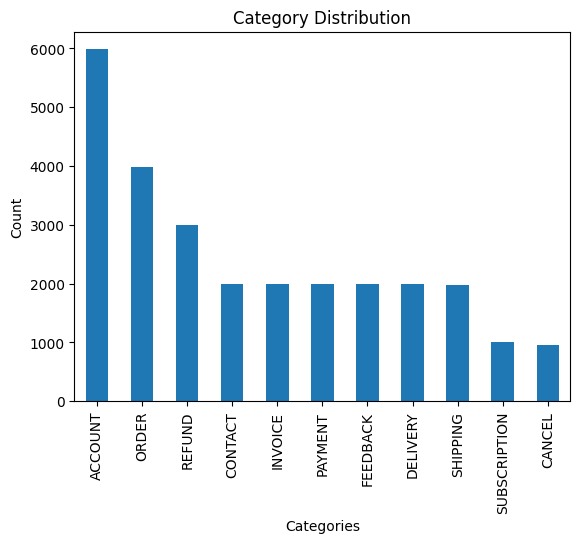

In [10]:
categories.plot.bar()
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.show()

In [11]:
# character count for instruction and response columns
df['instruction_length'] = df['instruction'].str.len()
df['response_length'] = df['response'].str.len()


df['instruction_word_count'] = df['instruction'].str.split().str.len()
df['response_word_count'] = df['response'].str.split().str.len()


print("\n--- Character Length Statistics ---")
print("\nInstructions:")
print(df['instruction_length'].describe())
print("\nResponses:")
print(df['response_length'].describe())

print("\n--- Word Count Statistics ---")
print("\nInstructions:")
print(df['instruction_word_count'].describe())
print("\nResponses:")
print(df['response_word_count'].describe())


--- Character Length Statistics ---

Instructions:
count    26872.000000
mean        46.889513
std         10.897578
min          6.000000
25%         40.000000
50%         48.000000
75%         55.000000
max         92.000000
Name: instruction_length, dtype: float64

Responses:
count    26872.000000
mean       634.104495
std        331.593822
min         57.000000
25%        427.000000
50%        540.000000
75%        753.000000
max       2472.000000
Name: response_length, dtype: float64

--- Word Count Statistics ---

Instructions:
count    26872.000000
mean         8.690979
std          2.605004
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         16.000000
Name: instruction_word_count, dtype: float64

Responses:
count    26872.000000
mean       104.789037
std         52.966204
min          9.000000
25%         72.000000
50%         90.000000
75%        124.000000
max        402.000000
Name: response_word_count, dtype: float64


In [12]:
df.head()

,flags,instruction,category,intent,response,instruction_length,response_length,instruction_word_count,response_word_count
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,48,212,6,37
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...,58,279,9,48
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...,47,1343,7,205
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...,42,1104,7,166
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...,60,1222,9,191


In [13]:
model_ckpt = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [14]:
# TODO: tokenize dataset

In [15]:
# TODO: potential train test split confirm later

In [16]:
tokenizer.vocab_size, tokenizer.model_max_length

(32100, 512)

In [17]:
# restore code to normal huggging face format for hugging face training
data.reset_format()

In [18]:
def tokenize(batch):
  temp = tokenizer(batch['instruction'], batch['response'], truncation=True, padding=True)
  # batch['input_ids'] = temp['input_ids']
  # batch['attention_mask'] = temp['attention_mask']
  return temp

In [19]:
# TODO: map tokenizer to entire dataset

# Build Model

In [20]:
model = AutoModel.from_pretrained(model_ckpt)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]